In [1]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],  # "Times", "Palatino", "New Century Schoolbook", "Bookman", 
    "axes.labelsize": 16
    })
import random
import csv
import pandas as pd
import h5py
import yt
# Own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p
# from nnc2p import NeuralNetwork # our own architecture
# Get dirs
import os
cwd = os.getcwd()# "Code" folder
master_dir = os.path.abspath(os.path.join(cwd, ".."))

# Introduction

We can run a few simulations in Gmunu. Looking at the .dat files (output from the simulations) is a bit trickier. Hence, we load them here and postprocess/discuss/plot the data in this Python notebook.

# Smooth sine wave

Define the analytic results

In [2]:
A = 0.2
v0 = 0.2
theta = 0.0

def rho_sol_pt(x,y,t):
    return 1.0 + A * np.sin(2.0 * np.pi * ( ( x * np.cos(theta) + y * np.sin(theta) ) - ( v0 * np.cos(theta) ) * t ) )

rho_sol = np.vectorize(rho_sol_pt)

def gamma(field, data):
    return  np.sqrt( 1.0 + (data['W_vel1']**2) )
def veloc1(field, data):
    return data['W_vel1'] / data['gamma']

Read in the Kastaun and neural net sine waves

In [16]:
fname = os.path.join(master_dir, "Data/kastaun_wave.dat")
kastaun_wave = yt.load(fname)
fname = os.path.join(master_dir, "Data/neuralnet_wave.dat")
neuralnet_wave = yt.load(fname)
fname = os.path.join(master_dir, "Data/mock_table_wave.dat")
mock_table_wave = yt.load(fname)

yt : [INFO     ] 2023-05-25 11:28:51,061 Parameters: current_time              = 2.0
yt : [INFO     ] 2023-05-25 11:28:51,061 Parameters: domain_dimensions         = [128   1   1]
yt : [INFO     ] 2023-05-25 11:28:51,065 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-25 11:28:51,065 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-25 11:28:51,069 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-05-25 11:28:51,240 Parameters: current_time              = 2.0
yt : [INFO     ] 2023-05-25 11:28:51,240 Parameters: domain_dimensions         = [128   1   1]
yt : [INFO     ] 2023-05-25 11:28:51,249 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-25 11:28:51,251 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-25 11:28:51,254 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-05-25 11:28:51,440 Parameters: current_time              = 2.0
yt : [INFO     ] 2023

In [17]:
# Final time of simulation 
T_final = float(kastaun_wave.current_time)
# Additional preprocessing - see Gmunu for the source of this
for wave in [kastaun_wave, neuralnet_wave, mock_table_wave]:
    # Add gamma and veloc1
    wave.add_field(('amrvac','gamma'),  function=gamma,  sampling_type='cell')
    wave.add_field(('amrvac','veloc1'), function=veloc1, sampling_type='cell')
# Get the plotdata
plotdata_kastaun   = kastaun_wave.ortho_ray(0, (0, 0))
plotdata_neuralnet = neuralnet_wave.ortho_ray(0, (0, 0))
plotdata_mock_table = mock_table_wave.ortho_ray(0, (0, 0))

yt : [WARNING  ] 2023-05-25 11:28:54,323 e not found and no parfile passed, can not set thermal_pressure.


## Solutions

### Kastaun and NNC2P

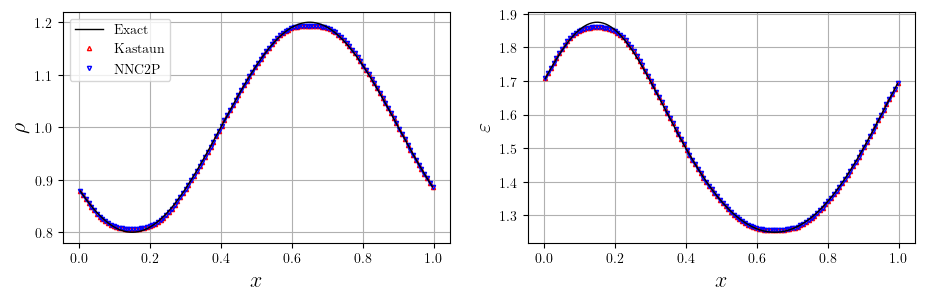

In [19]:
waves = [kastaun_wave, neuralnet_wave, mock_table_wave]
labels = ["Kastaun", "NNC2P", "Mock EOS table"]
colors = ["red", "blue", "purple"]
markers = ["^", "v", "^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1

# Limit:
# 2 -- don't plot mock EOS table
# 3 -- plot mock EOS table
limit = 2

fig, axs = plt.subplots(1, 2, figsize=(11,3))
(ax1, ax2) = axs

for i, wave in enumerate(waves[:limit]):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))

    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    
    # Exact values for this simulation
    if i == 0:
        exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
        exact_eps = (3/2) * (1/exact_vals)
        ax1.plot(np.array(plotdata['x'][srt]), exact_vals, '-', color="black", label="Exact", lw=lw, alpha = alpha, zorder=1000)
        ax2.plot(np.array(plotdata['x'][srt]), exact_eps, '-', color="black", label="Exact", lw=lw, alpha = alpha, zorder=1000)
    # The approximation
    ax1.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]), linestyle='',  color=colors[i], marker=markers[i], fillstyle=fillstyle, ms = ms, label=labels[i])
    ax2.plot(np.array(plotdata['x'][srt]), np.array(plotdata['eps'][srt]), linestyle='', color=colors[i], marker=markers[i], fillstyle=fillstyle, ms = ms, label=labels[i])
    
# Make a nice plot
ax1.set_ylabel(r"$\rho$")
ax2.set_ylabel(r"$\varepsilon$")
for ax in axs:
    ax.set_xlabel(r"$x$")
    ax.set_xlabel(r"$x$")
    ax.grid()
ax1.legend()
# plt.title("Smooth sine wave test")
if limit == 2:
    plt.savefig(os.path.join(master_dir, "Plots/smooth_wave_rho_kastaun_neuralnet.pdf"), bbox_inches='tight')
else:
    plt.savefig(os.path.join(master_dir, "Plots/smooth_wave_rho_kastaun_neuralnet_mock.pdf"), bbox_inches='tight')
plt.show()

### NNC2P and mock EOS table

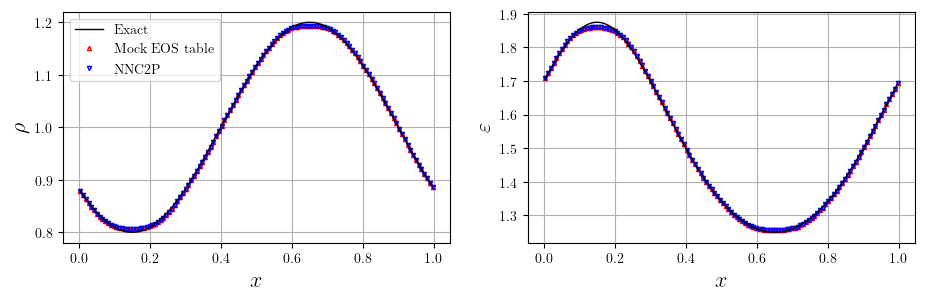

In [23]:
waves = [mock_table_wave, neuralnet_wave]
labels = ["Mock EOS table", "NNC2P"]
colors = ["red", "blue", "purple"]
markers = ["^", "v", "^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1

# Limit:
# 2 -- don't plot mock EOS table
# 3 -- plot mock EOS table
limit = 2

fig, axs = plt.subplots(1, 2, figsize=(11,3))
(ax1, ax2) = axs

for i, wave in enumerate(waves[:limit]):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))

    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    
    # Exact values for this simulation
    if i == 0:
        exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
        exact_eps = (3/2) * (1/exact_vals)
        ax1.plot(np.array(plotdata['x'][srt]), exact_vals, '-', color="black", label="Exact", lw=lw, alpha = alpha, zorder=1000)
        ax2.plot(np.array(plotdata['x'][srt]), exact_eps, '-', color="black", label="Exact", lw=lw, alpha = alpha, zorder=1000)
    # The approximation
    ax1.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]), linestyle='',  color=colors[i], marker=markers[i], fillstyle=fillstyle, ms = ms, label=labels[i])
    ax2.plot(np.array(plotdata['x'][srt]), np.array(plotdata['eps'][srt]), linestyle='', color=colors[i], marker=markers[i], fillstyle=fillstyle, ms = ms, label=labels[i])
    
# Make a nice plot
ax1.set_ylabel(r"$\rho$")
ax2.set_ylabel(r"$\varepsilon$")
for ax in axs:
    ax.set_xlabel(r"$x$")
    ax.set_xlabel(r"$x$")
    ax.grid()
ax1.legend()
plt.savefig(os.path.join(master_dir, "Plots/smooth_wave_rho_neuralnet_mock.pdf"), bbox_inches='tight')
plt.show()

In [7]:
print(f"{len(plotdata['x'][srt])} points in the plot")

128 points in the plot


## Differences

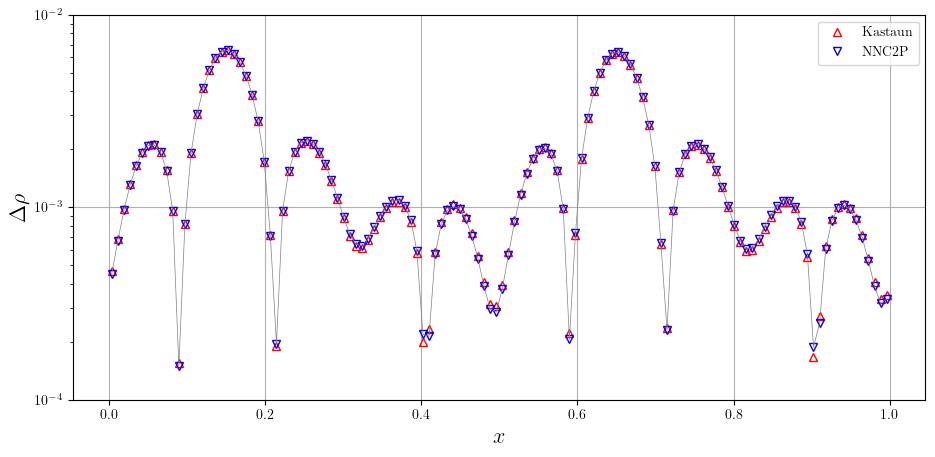

In [46]:
waves = [kastaun_wave, neuralnet_wave]
labels = ["Kastaun", "NNC2P"]
colors = ["red", "blue", "purple"]
markers = ["^", "v", "^"]
plotstyles = ["r^", "bv", "g^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1
small_delta = 0

# Limit:
# 2 -- don't plot mock EOS table
# 3 -- plot mock EOS table
limit = 2
plt.figure(figsize=(11,5))
for i, wave in enumerate(waves[:limit]):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))
    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    # Exact values for this simulation
    if i == 0:
        exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
    # Difference with numerical solution
    diffs_rho = abs(np.array(plotdata['rho'][srt]) - exact_vals)
    # Plot them
    plt.plot(np.array(plotdata['x'][srt]), diffs_rho, plotstyles[i], label = labels[i], fillstyle=fillstyle, lw = lw)

# Plot the line connecting them for clarity
plt.plot(np.array(plotdata['x'][srt]), diffs_rho, "-", color="gray",lw=0.5)
# Make a nice plot
plt.ylabel(r"$\Delta\rho$")
plt.xlabel(r"$x$")
plt.yscale('log')
plt.grid()
plt.legend()
# plt.title("Smooth sine wave test")
plt.ylim(1e-4 - small_delta, 1e-2 + small_delta)
plt.savefig(os.path.join(master_dir, "Plots/smooth_wave_rho_kastaun_neuralnet_diffs.pdf"), bbox_inches='tight')
plt.show()

In [43]:
print(f"The relative mean difference is: {np.mean(diffs)} pm {np.std(diffs)}")
print(f"The lowest and highest diff  is: {np.min(diffs)} , {np.max(diffs)}")

The relative mean difference is: 0.0017197218213032038 pm 0.0016313809984013971
The lowest and highest diff  is: 0.00015544049116111847 , 0.0065406137831616196


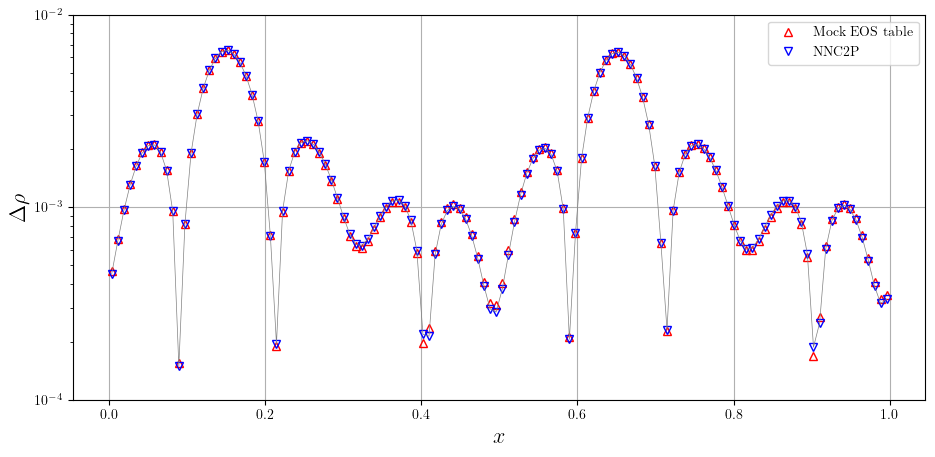

In [47]:
waves = [mock_table_wave, neuralnet_wave]
labels = ["Mock EOS table", "NNC2P"]
colors = ["red", "blue", "purple"]
markers = ["^", "v", "^"]
plotstyles = ["r^", "bv", "g^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1
small_delta = 0

# Limit:
# 2 -- don't plot mock EOS table
# 3 -- plot mock EOS table
limit = 2
plt.figure(figsize=(11,5))
for i, wave in enumerate(waves[:limit]):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))
    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    # Exact values for this simulation
    if i == 0:
        exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
    # Difference with numerical solution
    diffs_rho = abs(np.array(plotdata['rho'][srt]) - exact_vals)
    # Plot them
    plt.plot(np.array(plotdata['x'][srt]), diffs_rho, plotstyles[i], label = labels[i], fillstyle=fillstyle, lw = lw)

# Plot the line connecting them for clarity
plt.plot(np.array(plotdata['x'][srt]), diffs_rho, "-", color="gray",lw=0.5)
# Make a nice plot
plt.ylabel(r"$\Delta\rho$")
plt.xlabel(r"$x$")
plt.yscale('log')
plt.grid()
plt.legend()
# plt.title("Smooth sine wave test")
plt.ylim(1e-4 - small_delta, 1e-2 + small_delta)
plt.savefig(os.path.join(master_dir, "Plots/smooth_wave_rho_mock_neuralnet_diffs.pdf"), bbox_inches='tight')
plt.show()

## Sanity check: mock table is different from exact Kastaun

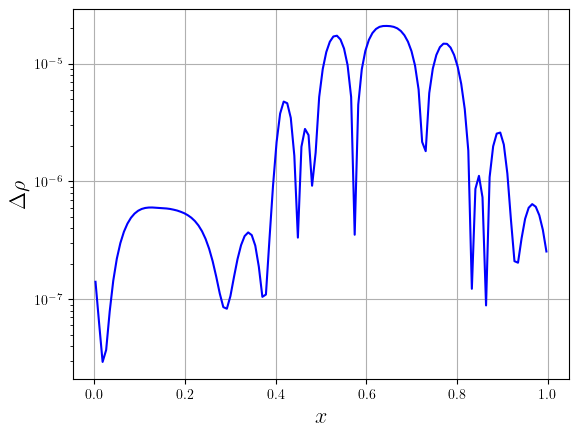

In [56]:
kastaun_check = kastaun_wave.ortho_ray(0, (0, 0))
srt = np.argsort(kastaun_check['x'])
kastaun_rho_check = np.array(kastaun_check['rho'][srt])

mock_check = mock_table_wave.ortho_ray(0, (0, 0))
srt = np.argsort(mock_check['x'])
mock_rho_check = np.array(mock_check['rho'][srt])

diffs_kastaun_mock = abs(kastaun_rho_check - mock_rho_check)

plt.plot(np.array(mock_check['x'][srt]), diffs_kastaun_mock, color="blue", label=r"|Kastaun - mock EOS table|")
plt.grid()
# plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$\Delta\rho$")
plt.yscale('log')
plt.savefig(os.path.join(master_dir, "Plots/smooth_wave_rho_mock_neuralnet_diffs.pdf"), bbox_inches='tight')

plt.show()

In [57]:
print(f"Average error by mock EOS table: {np.mean(diffs_kastaun_mock)}")

Average error by mock EOS table: 4.650274456266014e-06


__TODO__ how to get other entries in the .dat file?

# Shocktube

In [58]:
# Load the datasets
kastaun_shock = yt.load(os.path.join(master_dir, "Data/kastaun_shock.dat"))
kastaun_shock.add_field( ('amrvac','gamma'), function=gamma, sampling_type='cell')
kastaun_shock.add_field( ('amrvac','veloc1'), function=veloc1, sampling_type='cell')

neuralnet_shock = yt.load(os.path.join(master_dir, "Data/neuralnet_shock.dat"))
neuralnet_shock.add_field( ('amrvac','gamma'), function=gamma, sampling_type='cell')
neuralnet_shock.add_field( ('amrvac','veloc1'), function=veloc1, sampling_type='cell')

mock_table_shock = yt.load(os.path.join(master_dir, "Data/mock_table_shock.dat"))
mock_table_shock.add_field( ('amrvac','gamma'), function=gamma, sampling_type='cell')
mock_table_shock.add_field( ('amrvac','veloc1'), function=veloc1, sampling_type='cell')

yt : [INFO     ] 2023-05-25 11:59:43,766 Parameters: current_time              = 0.4
yt : [INFO     ] 2023-05-25 11:59:43,766 Parameters: domain_dimensions         = [16  1  1]
yt : [INFO     ] 2023-05-25 11:59:43,766 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-25 11:59:43,778 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-25 11:59:43,783 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2023-05-25 11:59:43,880 e not found and no parfile passed, can not set thermal_pressure.
yt : [INFO     ] 2023-05-25 11:59:44,466 Parameters: current_time              = 0.4
yt : [INFO     ] 2023-05-25 11:59:44,466 Parameters: domain_dimensions         = [16  1  1]
yt : [INFO     ] 2023-05-25 11:59:44,469 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-25 11:59:44,469 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-25 11:59:44,469 Parameters: cosmological_simulation   = 0
yt : [

Get the data

In [67]:
# cutting the x-axis through the y=0,z=0 
plotdata_kastaun = kastaun_shock.ortho_ray( 0, (0, 0) )
plotdata_neuralnet = neuralnet_shock.ortho_ray( 0, (0, 0) )
plotdata_mock_table = mock_table_shock.ortho_ray( 0, (0, 0) )

# Sort the ray values by 'x' so there are no discontinuities in the line plot
kastaun_srt = np.argsort(plotdata_kastaun['x'])
neuralnet_srt = np.argsort(plotdata_neuralnet['x'])
mock_table_srt = np.argsort(plotdata_mock_table['x'])

keys: rho, press, veloc1

## Solutions

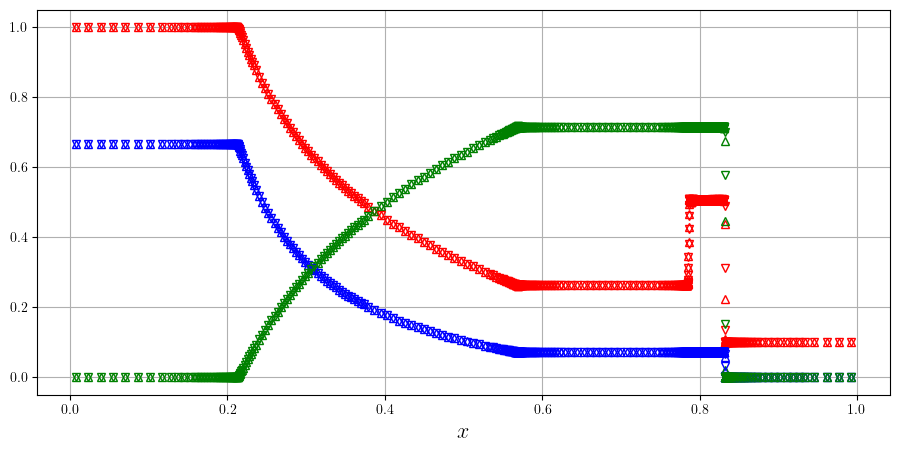

In [70]:
plotdata_list = [plotdata_kastaun, plotdata_neuralnet]
labels = ["Mock EOS table", "NNC2P"]
colors = ["red", "blue", "green"]
markers = ["^", "v", "^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1
small_delta = 0

# Limit:
# 2 -- don't plot mock EOS table
# 3 -- plot mock EOS table
limit = 2
plt.figure(figsize=(11,5))
for i, plotdata in enumerate(plotdata_list[:limit]):
    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    # Exact values for this simulation
#     if i == 0:
#         exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
    # Difference with numerical solution
    # Plot them
    plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]/10), linestyle='', color = "red", marker=markers[i], label = labels[i], fillstyle=fillstyle, lw = lw)
    plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['press'][srt]/20), linestyle='', color = "blue", marker=markers[i], label = labels[i], fillstyle=fillstyle, lw = lw)
    plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['veloc1'][srt]), linestyle='', color = "green", marker=markers[i], label = labels[i], fillstyle=fillstyle, lw = lw)

# Make a nice plot
plt.xlabel(r"$x$")
plt.grid()
# plt.legend()
plt.savefig(os.path.join(master_dir, "Plots/shocktube_rho_kastaun_neuralnet.pdf"), bbox_inches='tight')
plt.show()

Reference:

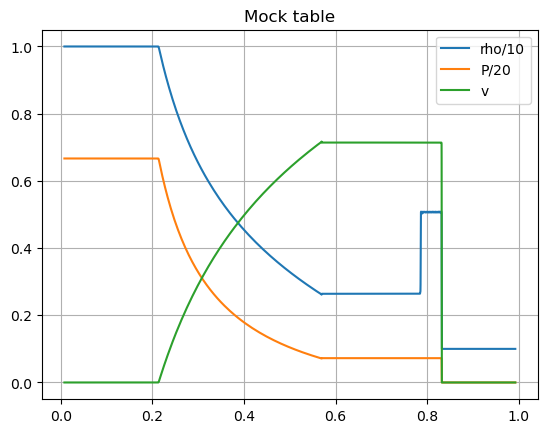

In [19]:
# Plot the data
plotdata = plotdata_mock_table
srt = np.argsort(plotdata['x'])
plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]/10), label='rho/10')
plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['press'][srt]/20), label='P/20')
plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['veloc1'][srt]), label='v')

# Save the line plot
plt.legend(loc='best')
plt.title("Mock table")
plt.grid()
plt.show()

# Convergence plots

Directory location:

In [71]:
conv_wave_dir = os.path.join(master_dir, "Data/convergence_results/conv_wave")
conv_shock_dir = os.path.join(master_dir, "Data/convergence_results/conv_shocktube")

The grid sizes that were used:

In [72]:
grid_sizes = [100, 200, 400, 800, 1600, 3200]

## Smooth sine wave

The analytic solution to the problem:

TODO - get the neural net error on the prims for a very large sample?

In [73]:
A = 0.2
v0 = 0.2
theta = 0.0

def rho_sol_pt(x,y,t):
    return 1.0 + A * np.sin(2.0 * np.pi * ( ( x * np.cos(theta) + y * np.sin(theta) ) - ( v0 * np.cos(theta) ) * t ) )

rho_sol = np.vectorize(rho_sol_pt)

def gamma(field, data):
    return  np.sqrt( 1.0 + (data['W_vel1']**2) )
def veloc1(field, data):
    return data['W_vel1'] / data['gamma']

Auxiliary method to find the numerical error from a simulation file

In [120]:
def get_all_errors(dat, grid_sizes, var_names = ["rho", "eps", "press", "veloc1"], exact_sol = rho_sol, T_final=5.0, which="sine"):
    """
    Returns a list of errors for different grids
    
    Dat: list of loaded data files to get the values of simulations from.
    """
    # Initialize empty dicts:
    # each dict: key for the var names, every value has errors for increasing grid size
    l1_dict = {}
    linfty_dict = {}
    for var in var_names:
        l1_dict[var] = []
        linfty_dict[var] = []
    
    # Iterate over each var name
    for i, grid_size in enumerate(grid_sizes):
        this_grid_data = dat[i]
        for var in var_names:
            if which == "shocktube":
                print("Not implemented")
                return l1_dict, linfty_dict
            else:
                l1, linfty = compute_error_sine(this_grid_data, var_name=var, exact_sol=exact_sol, T_final=T_final)
                l1_dict[var].append(l1)
                linfty_dict[var].append(linfty)
    return l1_dict, linfty_dict

def compute_error_sine(dat, var_name = "rho", exact_sol = rho_sol, T_final=5.0):
    """Computes error based on the exact sine wave"""
    # Get the plotdata
    plotdata   = dat.ortho_ray(0, (0, 0))
    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    # Get exact values and numerical solution values
    rho_vals = np.array(exact_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
    if var_name == "rho":
        exact_vals = rho_vals
    elif var_name == "veloc1":
        exact_vals = v0
    elif var_name == "press":
        exact_vals = 1
    elif var_name == "eps":
        exact_vals = (3/2) * (1/rho_vals)
    else:
        print("Not recognized")
        return 0, 0
    num_vals = np.array(plotdata[var_name][srt])
    # Get the differences
    diffs = abs(num_vals - exact_vals)
    
    # Append errors
    #l1 = np.mean(diffs)  # replaced by delta_N!
    l1 = np.sum(diffs)/np.sum(abs(exact_vals))
    # ^ this is delta_N, defined in Gmunu parallel, grid-adaptive,... paper!!!
    linfty = np.max(diffs)
    
    return l1, linfty

Read in the Kastaun and neural net sine waves

In [110]:
kastaun_data = []
neuralnet_data = []
for grid_size in grid_sizes:
    # Kastaun:
    fname = os.path.join(conv_wave_dir, f"kastaun_{grid_size}.dat")
    dat = yt.load(fname)
    dat.add_field(('amrvac','gamma'),  function=gamma,  sampling_type='cell')
    dat.add_field(('amrvac','veloc1'), function=veloc1, sampling_type='cell')
    kastaun_data.append(dat)
    # Neuralnet:
    fname = os.path.join(conv_wave_dir, f"neuralnet_{grid_size}.dat")
    dat = yt.load(fname)
    dat.add_field(('amrvac','gamma'),  function=gamma,  sampling_type='cell')
    dat.add_field(('amrvac','veloc1'), function=veloc1, sampling_type='cell')
    neuralnet_data.append(dat)

yt : [INFO     ] 2023-05-25 14:17:42,477 Parameters: current_time              = 5.0
yt : [INFO     ] 2023-05-25 14:17:42,479 Parameters: domain_dimensions         = [100   1   1]
yt : [INFO     ] 2023-05-25 14:17:42,483 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-25 14:17:42,487 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-25 14:17:42,490 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2023-05-25 14:17:42,523 e not found and no parfile passed, can not set thermal_pressure.
yt : [INFO     ] 2023-05-25 14:17:43,124 Parameters: current_time              = 5.0
yt : [INFO     ] 2023-05-25 14:17:43,132 Parameters: domain_dimensions         = [100   1   1]
yt : [INFO     ] 2023-05-25 14:17:43,132 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-25 14:17:43,135 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-25 14:17:43,135 Parameters: cosmological_simulation   = 0


Compute the errors and convergence rates

In [137]:
kastaun_l1, kastaun_linfty = get_all_errors(kastaun_data, grid_sizes)
neuralnet_l1, neuralnet_linfty = get_all_errors(neuralnet_data, grid_sizes)

In [138]:
convergence_rates = []
for data in l1_values:
    rates = []
    for i in range(1, len(grid_sizes)):
        value = np.log2(data["rho"][i-1]/data["rho"][i])
        rates.append(value)
    convergence_rates.append(rates)

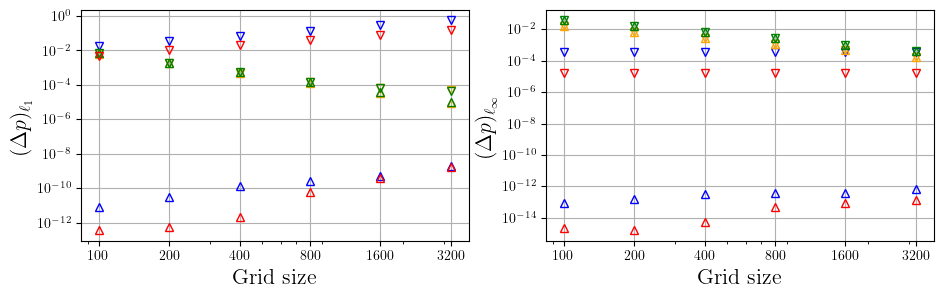

In [124]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(11,3))
alph=1
ax1, ax2 = axs
color_dict = {"press": "blue", "rho": "orange", "eps": "green", "veloc1": "red"}
markers = ["^", "v"] # kastaun, neuralnet

l1_values = [kastaun_l1, neuralnet_l1]
linfty_values = [kastaun_linfty, neuralnet_linfty]

for var in color_dict.keys():
    for i in range(len(l1_values)):
        # L1 rate
        ax1.plot(grid_sizes, l1_values[i][var], linestyle='', marker=markers[i], color = color_dict[var], alpha=alph, fillstyle="none")
        ax1.set_ylabel(r"$(\Delta p)_{\ell_1}$")
        
        ax2.plot(grid_sizes, linfty_values[i][var], linestyle='', marker=markers[i], color = color_dict[var], alpha=alph, fillstyle="none")
        ax2.set_ylabel(r"$(\Delta p)_{\ell_\infty}$")

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Grid size")
    ax.set_xticks(grid_sizes, labels=grid_sizes)
    ax.grid()
#     ax.legend()
# plt.savefig(os.path.join(master_dir, "Plots/Final_plots/convergence_runs_wave.pdf"), bbox_inches='tight')
plt.show()

### Compare convergence rates (uses rho only)!

Convergence rate: see Gmunu paper ("parallel, grid adaptive,...")

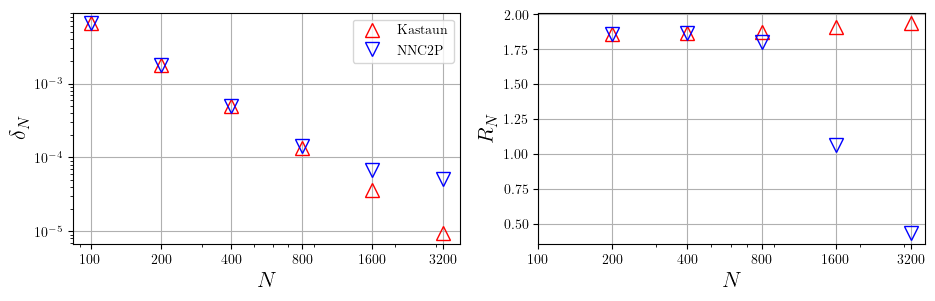

In [156]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(11,3))
alph=1
ms = 10
ax1, ax2 = axs
color_dict = {"press": "blue", "rho": "orange", "eps": "green", "veloc1": "red"}
markers = ["^", "v"] # kastaun, neuralnet
labels = ["Kastaun", "NNC2P"]

l1_values = [kastaun_l1, neuralnet_l1]
linfty_values = [kastaun_linfty, neuralnet_linfty]

for i in range(len(l1_values)):
    # delta N
    ax1.plot(grid_sizes, l1_values[i]["rho"], linestyle='', marker=markers[i], ms=ms, color = colors[i], label=labels[i], alpha=alph, fillstyle="none")
    ax1.set_ylabel(r"$\delta_N$")
    # Line for ideal scaling
#     if i == 0:
#         line_x = np.arange(grid_sizes[0], grid_sizes[-1], 0.01)
#         y0 = 0.000001
#         line_y = y0 + (line_x - grid_sizes[0])**(-2)
#         ax1.plot(line_x, line_y, "--", color="black")

    # R_N
    ax2.plot(grid_sizes[1:], convergence_rates[i], linestyle='', marker=markers[i], ms=ms, color = colors[i], alpha=alph, fillstyle="none")
    ax2.set_ylabel(r"$R_N$")

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlabel(r"$N$")
    ax.set_xticks(grid_sizes, labels=grid_sizes)
    ax.grid()
ax1.legend()
plt.savefig("../Plots/Final/convergence_runs_wave.pdf", bbox_inches='tight')
ax1.set_yscale('log')
plt.show()

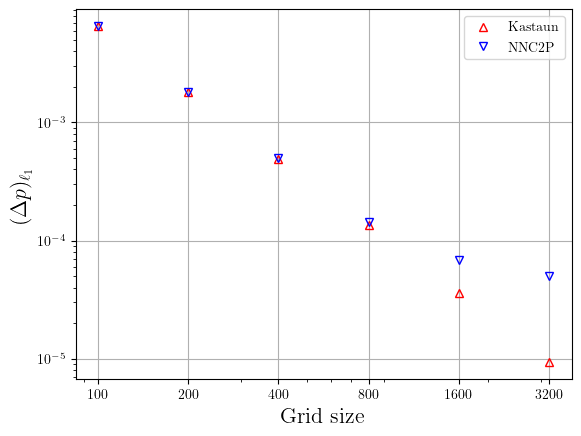

In [127]:
# alph=1
# markers = ["^", "v"] # kastaun, neuralnet
# colors = ["red", "blue"]
# labels = ["Kastaun", "NNC2P"]

# l1_values = [kastaun_l1, neuralnet_l1]

# for i in range(len(l1_values)):
#     # L1 rate
#     plt.plot(grid_sizes, l1_values[i]["rho"], linestyle='', marker=markers[i], color = colors[i], label=labels[i], alpha=alph, fillstyle="none")

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel("Grid size $N$")
# plt.ylabel(r"$\delta_N$")
# plt.xticks(grid_sizes, labels=grid_sizes)
# plt.grid()
# plt.legend()
# # plt.savefig(os.path.join(master_dir, "Plots/Final_plots/convergence_runs_wave.pdf"), bbox_inches='tight')
# plt.show()

Get convergence rates:

In [136]:
all_rates

[[1.8595005928973545,
  1.8684852070688907,
  1.8712005178165254,
  1.9121368107668946,
  1.9357437548179692],
 [1.8590350025325542,
  1.8631411190024674,
  1.802784593549507,
  1.0672074433697882,
  0.43195003367426005]]

## Shocktube

TODO - how do I get the analytic results?

In [19]:
def get_errors_shock(dat):
    # Get the plotdata
    plotdata   = dat.ortho_ray(0, (0, 0))
    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    # Get exact values and numerical solution values
    exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
    num_vals = plotdata['rho'][srt]
    # Get the differences
    diffs = abs(np.array(plotdata['rho'][srt]) - exact_vals)
    # Append errors
    l1 = np.mean(diffs)
    linfty = np.max(diffs)
    
    return l1, linfty

Read in the Kastaun and neural net sine waves

In [20]:
kastaun_data = []
neuralnet_data = []
for grid_size in grid_sizes:
    # Kastaun:
    fname = os.path.join(conv_shock_dir, f"kastaun_{grid_size}.dat")
    dat = yt.load(fname)
    #wave.add_field(('amrvac','gamma'),  function=gamma,  sampling_type='cell')
    #wave.add_field(('amrvac','veloc1'), function=veloc1, sampling_type='cell')
    kastaun_data.append(dat)
    # Neuralnet:
    fname = os.path.join(conv_shock_dir, f"neuralnet_{grid_size}.dat")
    dat = yt.load(fname)
    neuralnet_data.append(dat)

yt : [INFO     ] 2023-05-11 15:27:00,127 Parameters: current_time              = 5.0
yt : [INFO     ] 2023-05-11 15:27:00,128 Parameters: domain_dimensions         = [100   1   1]
yt : [INFO     ] 2023-05-11 15:27:00,129 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-11 15:27:00,130 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-11 15:27:00,131 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-05-11 15:27:00,204 Parameters: current_time              = 5.0
yt : [INFO     ] 2023-05-11 15:27:00,205 Parameters: domain_dimensions         = [100   1   1]
yt : [INFO     ] 2023-05-11 15:27:00,207 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-11 15:27:00,208 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-11 15:27:00,209 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-05-11 15:27:00,291 Parameters: current_time              = 5.0
yt : [INFO     ] 2023

In [23]:
# Final time of simulation 
T_final = 5.0

kastaun_l1 = []
kastaun_linfty = []

neuralnet_l1 = []
neuralnet_linfty = []

# Get the errors for each simulation
for dat in kastaun_data:
    l1, linfty = get_errors(dat)
    kastaun_l1.append(l1)
    kastaun_linfty.append(linfty)
    
for dat in neuralnet_data:
    l1, linfty = get_errors(dat)
    neuralnet_l1.append(l1)
    neuralnet_linfty.append(linfty)

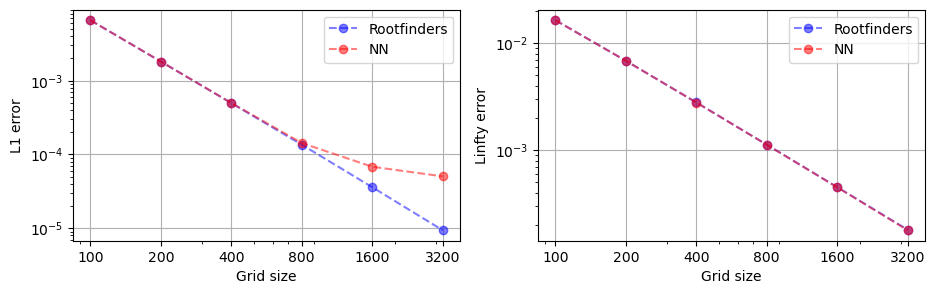

In [32]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(11,3))
alph = 0.5
ax1, ax2 = axs

ax1.plot(grid_sizes, kastaun_l1, '--o', color = "blue", label = "Rootfinders", alpha=alph)
ax1.plot(grid_sizes, neuralnet_l1, '--o', color = "red", label = "NN", alpha=alph)
ax1.set_ylabel("L1 error")

ax2.plot(grid_sizes, kastaun_linfty, '--o', color = "blue", label = "Rootfinders", alpha=alph)
ax2.plot(grid_sizes, neuralnet_linfty, '--o', color = "red", label = "NN", alpha=alph)
ax2.set_ylabel("Linfty error")

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Grid size")
    ax.set_xticks(grid_sizes, labels=grid_sizes)
    ax.grid()
    ax.legend()
# plt.savefig(os.path.join(master_dir, "Plots/Final_plots/convergence_runs_wave.pdf"), bbox_inches='tight')
plt.show()